**The purpose of this notebook is to classify job changes as lateral, promotion, demotion, or exit.**

# Set Up

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read in Data

In [ ]:
# File path to get data
file_path = '/content/drive/MyDrive/Vandy/Second Year/Spring semester/Capstone/Data/EY/ey_AuditConsultCategorized_employ_with_yrs_exp.gz'

# Read the compressed CSV file back into a df
df = pd.read_csv(file_path, compression='gzip')
df.head()

,id,job_number,onet,Title1,Title2,start_dt,end_dt,ey_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator
0,1282.0,5,13-2011.01,Staff Accountant,Staff Accountant,1987-01-01,1989-01-01,0,Auditing,1989-01-01 00:00:00.000000,2.001369,0.000000,False
1,1282.0,4,13-2011.01,Staff Accountant,Staff Accountant/Supervisor,1989-01-01,1991-01-01,0,Auditing,1991-01-01 00:00:00.000000,4.000000,0.000000,False
2,1282.0,0,11-2021.00,General Manager (Management),Manager,2011-08-01,NaN,1,Consulting,2024-03-31 21:22:05.518488,0.000000,12.665298,False
3,1406.0,2,13-2011.01,Banker,Associate,2007-01-01,2009-01-01,0,Auditing,2009-01-01 00:00:00.000000,2.001369,0.000000,True
4,1406.0,1,13-2011.01,Banker,Associate,2010-01-01,2011-01-01,0,Auditing,2011-01-01 00:00:00.000000,3.000684,0.000000,True


In [ ]:
df.shape # should be 393,560 rows by 13 cols

(393560, 13)

# Copy DF

In [ ]:
# Copy over entire df to make edits. Want to keep the original df the same.
df2 = df.copy()
df2.head()

,id,job_number,onet,Title1,Title2,start_dt,end_dt,ey_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator
0,1282.0,5,13-2011.01,Staff Accountant,Staff Accountant,1987-01-01,1989-01-01,0,Auditing,1989-01-01 00:00:00.000000,2.001369,0.000000,False
1,1282.0,4,13-2011.01,Staff Accountant,Staff Accountant/Supervisor,1989-01-01,1991-01-01,0,Auditing,1991-01-01 00:00:00.000000,4.000000,0.000000,False
2,1282.0,0,11-2021.00,General Manager (Management),Manager,2011-08-01,NaN,1,Consulting,2024-03-31 21:22:05.518488,0.000000,12.665298,False
3,1406.0,2,13-2011.01,Banker,Associate,2007-01-01,2009-01-01,0,Auditing,2009-01-01 00:00:00.000000,2.001369,0.000000,True
4,1406.0,1,13-2011.01,Banker,Associate,2010-01-01,2011-01-01,0,Auditing,2011-01-01 00:00:00.000000,3.000684,0.000000,True


In [ ]:
df2.dtypes

id                         float64
job_number                   int64
onet                        object
Title1                      object
Title2                      object
start_dt                    object
end_dt                      object
ey_ind                       int64
Categorization              object
new_end_dt                  object
Total_Audit_Years          float64
Total_Consulting_Years     float64
Audit_Focused_Indicator       bool
dtype: object

# Exit Move

In [ ]:
df2['start_dt'] = pd.to_datetime(df2['start_dt'])
df2['new_end_dt'] = pd.to_datetime(df2['new_end_dt'])

# Sort the df by id and start date
df2.sort_values(by=['id', 'start_dt'], inplace=True)

# Identify exits based on the specified conditions
# Checks if the current job has ey_ind == 1 (which means it is a EY job),
# then next job has ey_ind == 0 (nonEY job), and the start date of the next job
# is after the end date of the current job. If the conditions are met, label the 'exit' column as True
# indicating that the person has left EY for another job outside EY.
df2['Exit'] = (df2['ey_ind'] == 1) & (df2['ey_ind'].shift(-1) == 0) & (df2['start_dt'].shift(-1) > df2['new_end_dt']) # label true or false. Counts come from this column

# Group by occupation and year to calculate counts and rates
# For each group, calculate the sum and count of the exit column.
# The sum represents the number of True values (exits), and count represents the total number of rows in the group
exit_analysis = df2.groupby(['onet', df2['start_dt'].dt.year])['Exit'].agg(['sum', 'count']).reset_index()

# Calculate exit rate as the ratio of number of exits / total count, amt of rows
exit_analysis['Exit_Rate'] = exit_analysis['sum'] / exit_analysis['count']

# Rename columns
exit_analysis.columns = ['Occupation', 'Year', 'Exit_Count', 'Total_Count', 'Exit_Rate']

exit_analysis # 1159 rows × 5 columns

,Occupation,Year,Exit_Count,Total_Count,Exit_Rate
0,11-2021.00,1900.0,0,1,0.0
1,11-2021.00,1957.0,0,1,0.0
2,11-2021.00,1959.0,1,1,1.0
3,11-2021.00,1965.0,1,2,0.5
4,11-2021.00,1966.0,0,2,0.0
...,...,...,...,...,...
1154,43-9041.00,2006.0,0,1,0.0
1155,43-9041.00,2010.0,0,1,0.0
1156,43-9041.00,2011.0,0,1,0.0
1157,43-9041.00,2014.0,0,1,0.0


# Validate Exit Analysis

In [ ]:
df.head() # original df

,id,job_number,onet,Title1,Title2,start_dt,end_dt,ey_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator
0,1282.0,5,13-2011.01,Staff Accountant,Staff Accountant,1987-01-01,1989-01-01,0,Auditing,1989-01-01 00:00:00.000000,2.001369,0.000000,False
1,1282.0,4,13-2011.01,Staff Accountant,Staff Accountant/Supervisor,1989-01-01,1991-01-01,0,Auditing,1991-01-01 00:00:00.000000,4.000000,0.000000,False
2,1282.0,0,11-2021.00,General Manager (Management),Manager,2011-08-01,NaN,1,Consulting,2024-03-31 21:22:05.518488,0.000000,12.665298,False
3,1406.0,2,13-2011.01,Banker,Associate,2007-01-01,2009-01-01,0,Auditing,2009-01-01 00:00:00.000000,2.001369,0.000000,True
4,1406.0,1,13-2011.01,Banker,Associate,2010-01-01,2011-01-01,0,Auditing,2011-01-01 00:00:00.000000,3.000684,0.000000,True


In [ ]:
df2.head() # edited df

,id,job_number,onet,Title1,Title2,start_dt,end_dt,ey_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator,Exit
0,1282.0,5,13-2011.01,Staff Accountant,Staff Accountant,1987-01-01,1989-01-01,0,Auditing,1989-01-01 00:00:00.000000,2.001369,0.000000,False,False
1,1282.0,4,13-2011.01,Staff Accountant,Staff Accountant/Supervisor,1989-01-01,1991-01-01,0,Auditing,1991-01-01 00:00:00.000000,4.000000,0.000000,False,False
2,1282.0,0,11-2021.00,General Manager (Management),Manager,2011-08-01,NaN,1,Consulting,2024-03-31 21:22:05.518488,0.000000,12.665298,False,False
3,1406.0,2,13-2011.01,Banker,Associate,2007-01-01,2009-01-01,0,Auditing,2009-01-01 00:00:00.000000,2.001369,0.000000,True,False
4,1406.0,1,13-2011.01,Banker,Associate,2010-01-01,2011-01-01,0,Auditing,2011-01-01 00:00:00.000000,3.000684,0.000000,True,False


In [ ]:
# Validate analysis
# Let's look specifically at ONET value 11-2021.00 during the year 1965. Let's pull up that data
# The result from the exit analysis if there is 1 exit count True, 2 total count and a 0.5 exit rate

validation_df = df2[(df2['start_dt'].dt.year == 1965) & (df2['onet'] == '11-2021.00')]
validation_df

,id,job_number,onet,Title1,Title2,start_dt,end_dt,ey_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator,Exit
198464,4.182439e+13,4,11-2021.00,General Manager (Management),Manager,1965-06-01,1975-06-01,1,Consulting,1975-06-01,0.0,9.998631,False,True
306698,6.449323e+13,19,11-2021.00,Reporting Leader,Leader,1965-01-01,1967-01-01,0,Consulting,1967-01-01,0.0,1.998631,False,False


Yes counts and ratio is right with 1 true exit and 2 total rows so 1/2 = 0.5 for this occupaion and year. Lets now confirm we are labelling Exit boolean column correctly.

In [ ]:
# Let's look at a specific ID
id = 	1282.0

validation_df2 = df2[(df2['id'] == id)]
validation_df2

,id,job_number,onet,Title1,Title2,start_dt,end_dt,ey_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator,Exit
0,1282.0,5,13-2011.01,Staff Accountant,Staff Accountant,1987-01-01,1989-01-01,0,Auditing,1989-01-01 00:00:00.000000,2.001369,0.000000,False,False
1,1282.0,4,13-2011.01,Staff Accountant,Staff Accountant/Supervisor,1989-01-01,1991-01-01,0,Auditing,1991-01-01 00:00:00.000000,4.000000,0.000000,False,False
2,1282.0,0,11-2021.00,General Manager (Management),Manager,2011-08-01,NaN,1,Consulting,2024-03-31 21:22:05.518488,0.000000,12.665298,False,False


Exit is True if leave EY for another job and has a sequential start date. This is because we only care about if they leave EY, not leave other jobs.

In [ ]:
# Another validation check of Exit analysis. Check is Exit boolean is labelling correctly
# Let's look at a specific ID
id = 1406.0

validation_df3 = df2[(df2['id'] == id)]
validation_df3

,id,job_number,onet,Title1,Title2,start_dt,end_dt,ey_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator,Exit
3,1406.0,2,13-2011.01,Banker,Associate,2007-01-01,2009-01-01,0,Auditing,2009-01-01,2.001369,0.0,True,False
4,1406.0,1,13-2011.01,Banker,Associate,2010-01-01,2011-01-01,0,Auditing,2011-01-01,3.000684,0.0,True,False


Yes, Exit boolean is labelling correctly.

# Promotion/Lateral Move
Categorize job transitions as promotions if more people move from job A to job B than from B to A, and as lateral moves if there is a more balanced flow between A to C and C to A.

In [ ]:
df2.head()

,id,job_number,onet,Title1,Title2,start_dt,end_dt,ey_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator,Exit
0,1282.0,5,13-2011.01,Staff Accountant,Staff Accountant,1987-01-01,1989-01-01,0,Auditing,1989-01-01 00:00:00.000000,2.001369,0.000000,False,False
1,1282.0,4,13-2011.01,Staff Accountant,Staff Accountant/Supervisor,1989-01-01,1991-01-01,0,Auditing,1991-01-01 00:00:00.000000,4.000000,0.000000,False,False
2,1282.0,0,11-2021.00,General Manager (Management),Manager,2011-08-01,NaN,1,Consulting,2024-03-31 21:22:05.518488,0.000000,12.665298,False,False
3,1406.0,2,13-2011.01,Banker,Associate,2007-01-01,2009-01-01,0,Auditing,2009-01-01 00:00:00.000000,2.001369,0.000000,True,False
4,1406.0,1,13-2011.01,Banker,Associate,2010-01-01,2011-01-01,0,Auditing,2011-01-01 00:00:00.000000,3.000684,0.000000,True,False


In [ ]:
# only want moves when employees worked at EY so when ey_ind = 1
ey_df = df2[df2['ey_ind'] == 1]
ey_df # 130,081 rows × 14 columns

,id,job_number,onet,Title1,Title2,start_dt,end_dt,ey_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator,Exit
2,1.282000e+03,0,11-2021.00,General Manager (Management),Manager,2011-08-01,NaN,1,Consulting,2024-03-31 21:22:05.518488,0.000000,12.665298,False,False
5,2.098000e+03,1,13-2011.02,Auditor,Auditor,1997-09-01,1999-09-01,1,Auditing,1999-09-01 00:00:00.000000,1.998631,0.000000,True,False
6,2.319000e+03,3,13-1111.00,Senior Consultant,Consultant,2013-04-01,2014-09-01,1,Consulting,2014-09-01 00:00:00.000000,0.000000,1.418207,False,True
11,4.694000e+03,8,13-2011.02,Audit Director,Audit Staff,1998-08-01,1999-08-01,1,Auditing,1999-08-01 00:00:00.000000,0.999316,0.000000,False,True
14,5.272000e+03,3,13-2011.01,Accountant,Accountant,2011-01-01,2013-02-01,1,Auditing,2013-02-01 00:00:00.000000,2.086242,0.000000,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393549,1.374218e+14,0,13-2011.01,Business Tax Consultant,Intern,2016-06-01,2016-07-31,1,Auditing,2016-07-31 00:00:00.000000,0.164271,0.000000,True,False
393551,1.374218e+14,6,11-9199.02,General Manager (Management),Manager,2000-01-01,2010-06-01,1,Auditing,2010-06-01 00:00:00.000000,10.414784,0.000000,True,True
393555,1.374304e+14,8,13-2011.02,Other,Assurance Associate,2014-08-01,2014-11-01,1,Auditing,2014-11-01 00:00:00.000000,0.251882,0.000000,True,False
393557,1.374304e+14,1,13-2011.01,Tax Associate,Tax Associate,2012-06-01,2016-10-01,1,Auditing,2016-10-01 00:00:00.000000,5.834360,0.000000,False,True


In [ ]:
# now sort by id and start date
df_sorted = ey_df.sort_values(by=['id', 'start_dt'])
# df_sorted

# apply same analysis/code used in Deloitte analysis

# Create a new column for the previous job title
df_sorted['Origin'] = df_sorted.groupby('id')['onet'].shift()

# Create a new df to store transitions
transitions_df = df_sorted[(df_sorted['onet'] != df_sorted['Origin']) & (df_sorted['start_dt'] > df_sorted['end_dt'].shift())][['Origin', 'onet']]
# this ensures start date of Destination is AFTER the orign end_date

# Count transitions
transitions_count = transitions_df.groupby(['Origin', 'onet']).size().reset_index().rename(columns={'onet': 'Destination', 0: 'Count'})

# Now want to know when the origin and destinations happen in other direction
transitions_count['Other Direction'] = transitions_count.apply(lambda row: transitions_count.loc[(transitions_count['Origin'] == row['Destination']) & (transitions_count['Destination'] == row['Origin']), 'Count'].iloc[0] if not transitions_count[(transitions_count['Origin'] == row['Destination']) & (transitions_count['Destination'] == row['Origin'])].empty else 0, axis=1)

# Add Counts
transitions_count['Total Moves'] = transitions_count['Count'] + transitions_count['Other Direction']

# Calculate Ratios
transitions_count['Ratio'] = transitions_count['Count'] / transitions_count['Total Moves']

transitions_count # only for people who were working AT EY, 129 rows × 6 columns


,Origin,Destination,Count,Other Direction,Total Moves,Ratio
0,11-2021.00,13-1111.00,24,203,227,0.105727
1,11-2021.00,13-1161.00,10,22,32,0.312500
2,11-2021.00,13-2011.01,29,174,203,0.142857
3,11-2021.00,13-2011.02,18,187,205,0.087805
4,11-2021.00,13-2099.04,1,1,2,0.500000
...,...,...,...,...,...,...
124,43-3031.00,13-2011.02,25,9,34,0.735294
125,43-3031.00,13-2051.00,5,2,7,0.714286
126,43-3031.00,13-2061.00,1,0,1,1.000000
127,43-3031.00,15-1121.00,1,0,1,1.000000


## Distribution of Ratios
This will help us label transition moves either as promotion, lateral, or demotion.

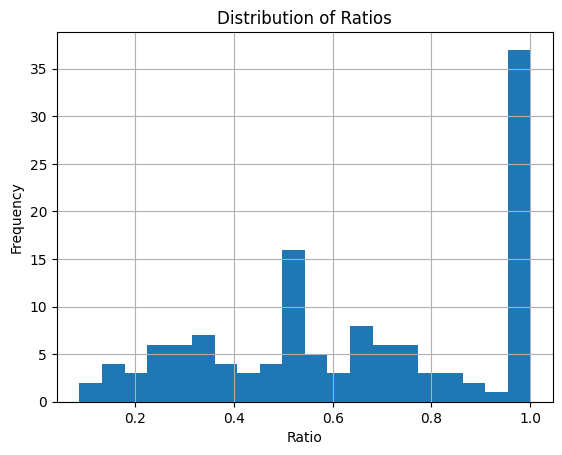

In [ ]:
import matplotlib.pyplot as plt

transitions_count['Ratio'].hist(bins=20) # bin size .05 which in this case is 20 bc the ratios are decimals
plt.title('Distribution of Ratios')
plt.xlabel('Ratio')
plt.ylabel('Frequency')
plt.show()

Labels Threshold:

0.0 - 0.35 = Demotion

0.36 - 0.74 = Lateral

0.75 - 1.0 = Promotion

## Label Ratios

In [ ]:
transitions_count['Job Move'] = pd.cut(transitions_count['Ratio'], bins=[-float('inf'), 0.36, 0.74, float('inf')], labels=['Demotion', 'Lateral', 'Promotion'], include_lowest=True)
transitions_count

,Origin,Destination,Count,Other Direction,Total Moves,Ratio,Job Move
0,11-2021.00,13-1111.00,24,203,227,0.105727,Demotion
1,11-2021.00,13-1161.00,10,22,32,0.312500,Demotion
2,11-2021.00,13-2011.01,29,174,203,0.142857,Demotion
3,11-2021.00,13-2011.02,18,187,205,0.087805,Demotion
4,11-2021.00,13-2099.04,1,1,2,0.500000,Lateral
...,...,...,...,...,...,...,...
124,43-3031.00,13-2011.02,25,9,34,0.735294,Lateral
125,43-3031.00,13-2051.00,5,2,7,0.714286,Lateral
126,43-3031.00,13-2061.00,1,0,1,1.000000,Promotion
127,43-3031.00,15-1121.00,1,0,1,1.000000,Promotion


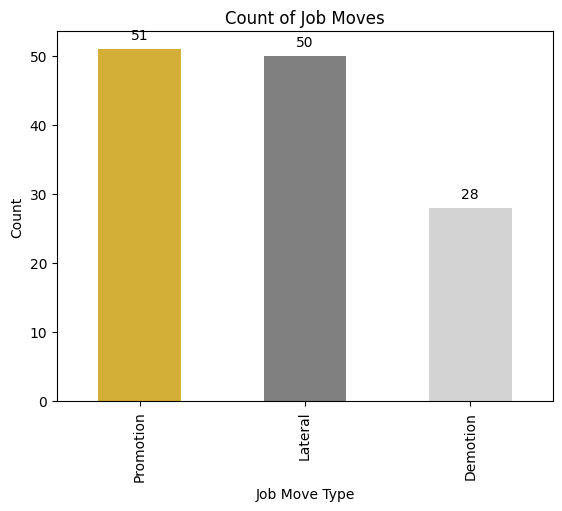

In [ ]:
job_move_counts = transitions_count['Job Move'].value_counts()

# Plot the bar chart with desired colors
ax = job_move_counts.plot(kind='bar', color=['#D4AF37', 'gray', 'lightgray'])  # Using hexadecimal color codes for honey gold and light gold
plt.title('Count of Job Moves')
plt.xlabel('Job Move Type')
plt.ylabel('Count')

# Add numeric values on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

Compared to Deloitte, there is a few more promotions in EY.

# Merge Data

In [ ]:
df2 # includes people who have worked at nonEY jobs

,id,job_number,onet,Title1,Title2,start_dt,end_dt,ey_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator,Exit
0,1.282000e+03,5,13-2011.01,Staff Accountant,Staff Accountant,1987-01-01,1989-01-01,0,Auditing,1989-01-01 00:00:00.000000,2.001369,0.000000,False,False
1,1.282000e+03,4,13-2011.01,Staff Accountant,Staff Accountant/Supervisor,1989-01-01,1991-01-01,0,Auditing,1991-01-01 00:00:00.000000,4.000000,0.000000,False,False
2,1.282000e+03,0,11-2021.00,General Manager (Management),Manager,2011-08-01,NaN,1,Consulting,2024-03-31 21:22:05.518488,0.000000,12.665298,False,False
3,1.406000e+03,2,13-2011.01,Banker,Associate,2007-01-01,2009-01-01,0,Auditing,2009-01-01 00:00:00.000000,2.001369,0.000000,True,False
4,1.406000e+03,1,13-2011.01,Banker,Associate,2010-01-01,2011-01-01,0,Auditing,2011-01-01 00:00:00.000000,3.000684,0.000000,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393555,1.374304e+14,8,13-2011.02,Other,Assurance Associate,2014-08-01,2014-11-01,1,Auditing,2014-11-01 00:00:00.000000,0.251882,0.000000,True,False
393556,1.374304e+14,2,13-2011.01,Accountant,Accountant,2010-12-01,2012-06-01,0,Auditing,2012-06-01 00:00:00.000000,1.500342,0.000000,False,False
393557,1.374304e+14,1,13-2011.01,Tax Associate,Tax Associate,2012-06-01,2016-10-01,1,Auditing,2016-10-01 00:00:00.000000,5.834360,0.000000,False,True
393558,1.374304e+14,0,13-2051.00,Financial Analyst,Financial Analyst,2016-11-01,NaN,0,Consulting,2024-03-31 21:22:05.518488,0.000000,7.411362,False,False


In [ ]:
# copy df over to make edits
df3 = df2.copy()
df3

,id,job_number,onet,Title1,Title2,start_dt,end_dt,ey_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator,Exit
0,1.282000e+03,5,13-2011.01,Staff Accountant,Staff Accountant,1987-01-01,1989-01-01,0,Auditing,1989-01-01 00:00:00.000000,2.001369,0.000000,False,False
1,1.282000e+03,4,13-2011.01,Staff Accountant,Staff Accountant/Supervisor,1989-01-01,1991-01-01,0,Auditing,1991-01-01 00:00:00.000000,4.000000,0.000000,False,False
2,1.282000e+03,0,11-2021.00,General Manager (Management),Manager,2011-08-01,NaN,1,Consulting,2024-03-31 21:22:05.518488,0.000000,12.665298,False,False
3,1.406000e+03,2,13-2011.01,Banker,Associate,2007-01-01,2009-01-01,0,Auditing,2009-01-01 00:00:00.000000,2.001369,0.000000,True,False
4,1.406000e+03,1,13-2011.01,Banker,Associate,2010-01-01,2011-01-01,0,Auditing,2011-01-01 00:00:00.000000,3.000684,0.000000,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393555,1.374304e+14,8,13-2011.02,Other,Assurance Associate,2014-08-01,2014-11-01,1,Auditing,2014-11-01 00:00:00.000000,0.251882,0.000000,True,False
393556,1.374304e+14,2,13-2011.01,Accountant,Accountant,2010-12-01,2012-06-01,0,Auditing,2012-06-01 00:00:00.000000,1.500342,0.000000,False,False
393557,1.374304e+14,1,13-2011.01,Tax Associate,Tax Associate,2012-06-01,2016-10-01,1,Auditing,2016-10-01 00:00:00.000000,5.834360,0.000000,False,True
393558,1.374304e+14,0,13-2051.00,Financial Analyst,Financial Analyst,2016-11-01,NaN,0,Consulting,2024-03-31 21:22:05.518488,0.000000,7.411362,False,False


In [ ]:
# check if NaT's in start date column
# There should not be any bc filled start_dt with prev job end_dt in prev classification notebook
nan = df3['start_dt'].isna()

# Create a df containing rows where NaT values are in the start_dt column
nan_rows_df = df3[nan]
nan_rows_df # there is 23,550 rows with NaT's in start_dt

,id,job_number,onet,Title1,Title2,start_dt,end_dt,ey_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator,Exit
82,8.589943e+09,2,13-2011.01,Financial Controller,Financial Controller,NaT,NaN,0,Auditing,2024-03-31 21:22:05.518488,NaN,0.0,True,False
83,8.589943e+09,3,15-2031.00,Supply Chain Analyst,Financial Analyst,NaT,NaN,0,Consulting,2024-03-31 21:22:05.518488,0.0,NaN,True,False
84,8.589943e+09,4,13-2011.02,Auditor,External Auditor,NaT,NaN,1,Auditing,2024-03-31 21:22:05.518488,NaN,0.0,True,False
85,8.589943e+09,5,13-2011.01,Finance Consultant,Finance Associate,NaT,NaN,0,Auditing,2024-03-31 21:22:05.518488,NaN,0.0,True,False
93,1.717987e+10,11,13-2011.01,Tax Accountant,Accountant,NaT,NaN,0,Auditing,2024-03-31 21:22:05.518488,NaN,0.0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393455,1.373015e+14,0,13-1111.00,Building Consultant,Consultant,NaT,NaN,1,Consulting,2024-03-31 21:22:05.518488,0.0,NaN,False,False
393469,1.373359e+14,10,11-2021.00,Enforcement Manager,Manager,NaT,NaN,0,Consulting,2024-03-31 21:22:05.518488,0.0,NaN,False,False
393483,1.373531e+14,0,13-2011.01,Tax Analyst,Associate Tax Analyst,NaT,NaN,1,Auditing,2024-03-31 21:22:05.518488,NaN,0.0,False,False
393487,1.373616e+14,0,13-2011.01,Staff Accountant,Staff Accountant,NaT,NaN,1,Auditing,2024-03-31 21:22:05.518488,NaN,0.0,False,False


In [ ]:
# let's look at specific rows and why they are NaT's start_dt because we should have
# solved this problem already

# Let's try listing all the ids
id_column = 'id'

# Count the number of unique onet values
num_unique_ids = nan_rows_df[id_column].nunique()

# List all onet values
unique_ids = nan_rows_df[id_column].unique()

print(f"Number of unique ID values: {num_unique_ids}")
print("List of IDs:")
print(unique_ids)

Number of unique ID values: 18955
List of IDs:
[8.58994348e+09 1.71798697e+10 1.71798708e+10 ... 1.37353054e+14
 1.37361644e+14 1.37430364e+14]


In [ ]:
# let's look at a specific ID
id = unique_ids[550]

check = nan_rows_df[(nan_rows_df['id'] == id)]
check

# These rows are NaT's because:
# 1. they only have one job entry and we can not fill start or end dts with only one data point
# 2. they have multiple data points and all have NaT for start_dt so can't infer dates

,id,job_number,onet,Title1,Title2,start_dt,end_dt,ey_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator,Exit
11383,2.413772e+12,4,13-1111.00,Risk Analyst,Risk Analyst,NaT,NaN,0,Consulting,2024-03-31 21:22:05.518488,0.0,NaN,False,False
11384,2.413772e+12,5,13-1111.00,Business Process Analyst,Business Process Analyst,NaT,NaN,0,Consulting,2024-03-31 21:22:05.518488,0.0,NaN,False,False


In [ ]:
# drop rows with NaT start date
df3_clean = df3.dropna(subset=['start_dt'])
df3_clean  # 370,010 rows × 14 columns

,id,job_number,onet,Title1,Title2,start_dt,end_dt,ey_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator,Exit
0,1.282000e+03,5,13-2011.01,Staff Accountant,Staff Accountant,1987-01-01,1989-01-01,0,Auditing,1989-01-01 00:00:00.000000,2.001369,0.000000,False,False
1,1.282000e+03,4,13-2011.01,Staff Accountant,Staff Accountant/Supervisor,1989-01-01,1991-01-01,0,Auditing,1991-01-01 00:00:00.000000,4.000000,0.000000,False,False
2,1.282000e+03,0,11-2021.00,General Manager (Management),Manager,2011-08-01,NaN,1,Consulting,2024-03-31 21:22:05.518488,0.000000,12.665298,False,False
3,1.406000e+03,2,13-2011.01,Banker,Associate,2007-01-01,2009-01-01,0,Auditing,2009-01-01 00:00:00.000000,2.001369,0.000000,True,False
4,1.406000e+03,1,13-2011.01,Banker,Associate,2010-01-01,2011-01-01,0,Auditing,2011-01-01 00:00:00.000000,3.000684,0.000000,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393554,1.374304e+14,0,13-2011.01,Financial Analyst,Financial Analyst,2017-01-01,NaN,0,Auditing,2024-03-31 21:22:05.518488,7.915127,0.000000,True,False
393555,1.374304e+14,8,13-2011.02,Other,Assurance Associate,2014-08-01,2014-11-01,1,Auditing,2014-11-01 00:00:00.000000,0.251882,0.000000,True,False
393556,1.374304e+14,2,13-2011.01,Accountant,Accountant,2010-12-01,2012-06-01,0,Auditing,2012-06-01 00:00:00.000000,1.500342,0.000000,False,False
393557,1.374304e+14,1,13-2011.01,Tax Associate,Tax Associate,2012-06-01,2016-10-01,1,Auditing,2016-10-01 00:00:00.000000,5.834360,0.000000,False,True


In [ ]:
df2.shape # check how many rows lost. Should be this 393560 - 23550 = 370010 rows.
# this is good

(393560, 14)

In [ ]:
# NaT's in new_end_dt col? There shouldn't be because we filled with todays date
nan = df3_clean['new_end_dt'].isna()
df3_clean[nan]

# No need to drop rows

,id,job_number,onet,Title1,Title2,start_dt,end_dt,ey_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator,Exit


In [ ]:
df3_clean.dtypes

id                                float64
job_number                          int64
onet                               object
Title1                             object
Title2                             object
start_dt                   datetime64[ns]
end_dt                             object
ey_ind                              int64
Categorization                     object
new_end_dt                 datetime64[ns]
Total_Audit_Years                 float64
Total_Consulting_Years            float64
Audit_Focused_Indicator              bool
Exit                                 bool
dtype: object

In [ ]:
# Now apply it to our df
# df3_clean['new_end_dt'] = pd.to_datetime(df3_clean['new_end_dt'])

# Create a list of years for each row
expanded_data = []
for _, row in df3_clean.iterrows():
    years = range(row['start_dt'].year, row['new_end_dt'].year + 1)
    for year in years:
        exit_value = 1 if row['Exit'] else 0 # convert exit column to boolean.
        # Exit is only if they LEFT EY for another nonEY job. 1 = True, 0 = False

        # Convert 'Audit_Focused_Indicator' to audit and consult history
        audit_history = 1 if row['Audit_Focused_Indicator'] else 0
        consult_history = 0 if row['Audit_Focused_Indicator'] else 1

        expanded_data.append({
            'ID': row['id'],
            'ONET': row['onet'],
            'Year': year,
            'Audit_History': audit_history,
            'Consult_History': consult_history,
            'Exit': exit_value})

expanded_df = pd.DataFrame(expanded_data)
expanded_df

,ID,ONET,Year,Audit_History,Consult_History,Exit
0,1.282000e+03,13-2011.01,1987,0,1,0
1,1.282000e+03,13-2011.01,1988,0,1,0
2,1.282000e+03,13-2011.01,1989,0,1,0
3,1.282000e+03,13-2011.01,1989,0,1,0
4,1.282000e+03,13-2011.01,1990,0,1,0
...,...,...,...,...,...,...
1630249,1.374304e+14,13-2051.00,2020,0,1,0
1630250,1.374304e+14,13-2051.00,2021,0,1,0
1630251,1.374304e+14,13-2051.00,2022,0,1,0
1630252,1.374304e+14,13-2051.00,2023,0,1,0


In [ ]:
# Let's validate data by looking at specific IDs
unique_values = expanded_df['ID'].unique()
print(unique_values)
print(unique_values[0])

[1.28200000e+03 1.40600000e+03 2.09800000e+03 ... 1.37430364e+14
 1.37430364e+14 1.37430364e+14]
1282.0


In [ ]:
filtered_df = expanded_df[expanded_df['ID'] == 1282.0]
filtered_df

,ID,ONET,Year,Audit_History,Consult_History,Exit
0,1282.0,13-2011.01,1987,0,1,0
1,1282.0,13-2011.01,1988,0,1,0
2,1282.0,13-2011.01,1989,0,1,0
3,1282.0,13-2011.01,1989,0,1,0
4,1282.0,13-2011.01,1990,0,1,0
5,1282.0,13-2011.01,1991,0,1,0
6,1282.0,11-2021.00,2011,0,1,0
7,1282.0,11-2021.00,2012,0,1,0
8,1282.0,11-2021.00,2013,0,1,0
9,1282.0,11-2021.00,2014,0,1,0


In [ ]:
# Let's validate data by looking at specific IDs
filtered_df2 = df3_clean[df3_clean['id'] == 1282.0]
filtered_df2
# we can see for id 1282.0 it expanded correctly

,id,job_number,onet,Title1,Title2,start_dt,end_dt,ey_ind,Categorization,new_end_dt,Total_Audit_Years,Total_Consulting_Years,Audit_Focused_Indicator,Exit
0,1282.0,5,13-2011.01,Staff Accountant,Staff Accountant,1987-01-01,1989-01-01,0,Auditing,1989-01-01 00:00:00.000000,2.001369,0.000000,False,False
1,1282.0,4,13-2011.01,Staff Accountant,Staff Accountant/Supervisor,1989-01-01,1991-01-01,0,Auditing,1991-01-01 00:00:00.000000,4.000000,0.000000,False,False
2,1282.0,0,11-2021.00,General Manager (Management),Manager,2011-08-01,NaN,1,Consulting,2024-03-31 21:22:05.518488,0.000000,12.665298,False,False


In [ ]:
# Make sure there are not 1's in both audit and consult history columns at the same time
filtered_df3 = expanded_df[(expanded_df['Audit_History'] == 1) & expanded_df['Consult_History'] == 1]
filtered_df3

,ID,ONET,Year,Audit_History,Consult_History,Exit


In [ ]:
# Make sure there are not 0's in both audit and consult history columns at the same time
filtered_df4 = expanded_df[(expanded_df['Audit_History'] == 0) & (expanded_df['Consult_History'] == 0)]
filtered_df4

,ID,ONET,Year,Audit_History,Consult_History,Exit


Spot checks are good.

In [ ]:
# Now add in CEO focus to the dataset
file_path = '/content/drive/MyDrive/Vandy/Second Year/Spring semester/Capstone/Data/Big 4 CEO Dataset.xlsx'

ceo = pd.read_excel(file_path)
ceo

,Name,Firm,Tenure Start,Tenure End,Tenure Years,Employment History (Audit or Consulting),Terms
0,Joe Ucuzoglu,Deloitte,2022,2023,1,Audit,1
1,Punit Renjen,Deloitte,2015,2022,8,Consulting,2
2,Barry Salzberg,Deloitte,2011,2015,4,Tax,1
3,James Quigley,Deloitte,2007,2011,4,Audit,1
4,William Parrett,Deloitte,2003,2007,4,Audit,1
5,James Copeland,Deloitte,1999,2003,4,Audit,1
6,William Thomas,KPMG,2017,2023,6,Audit,2
7,John Veihmeyer,KPMG,2014,2017,3,Audit,1
8,Michael Andrew,KPMG,2011,2014,3,Tax,1
9,Timothy Flynn,KPMG,2007,2011,3,Audit,1


In [ ]:
# only want ceo data from EY
ceo_ey = ceo[ceo['Firm'] == 'EY']
ceo_ey

,Name,Firm,Tenure Start,Tenure End,Tenure Years,Employment History (Audit or Consulting),Terms
12,Carmine Di Sibio,EY,2019,2023,5,Consulting,1
13,Mark Weinberger,EY,2013,2019,6,Tax,1
14,Jim Turley,EY,2001,2013,12,Consulting,2
15,Philip Laskawy,EY,1994,2001,6,Audit,1


In [ ]:
# function to find EY CEO focus at a given year
def get_ceo_focus(year):
    ceo_row = ceo_ey[(ceo_ey['Tenure Start'] <= year) & (ceo_ey['Tenure End'] >= year)]
    if not ceo_row.empty:
        return ceo_row.iloc[0]['Employment History (Audit or Consulting)']
    else:
        return None

# Apply the function to each row in expanded_df to get the CEO focus during that id time
expanded_df['CEO Focus'] = expanded_df['Year'].apply(get_ceo_focus)
expanded_df.head()

,ID,ONET,Year,Audit_History,Consult_History,Exit,CEO Focus
0,1282.0,13-2011.01,1987,0,1,0,None
1,1282.0,13-2011.01,1988,0,1,0,None
2,1282.0,13-2011.01,1989,0,1,0,None
3,1282.0,13-2011.01,1989,0,1,0,None
4,1282.0,13-2011.01,1990,0,1,0,None


In [ ]:
expanded_df.shape # make sure didn't lose data. Did not which is good.
# should be 1,630,254 rows

(1630254, 7)

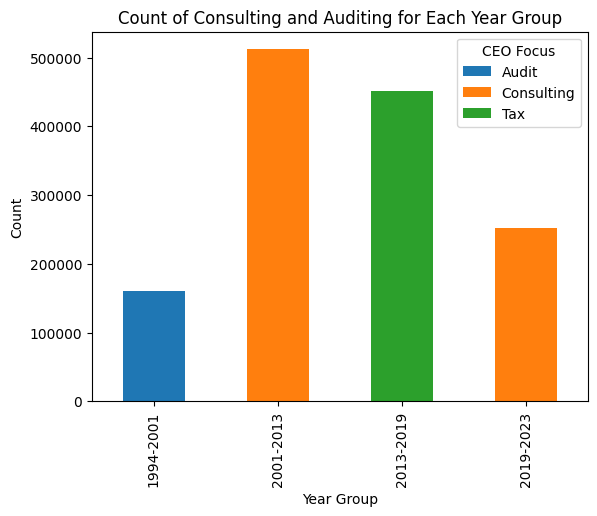

In [ ]:
# bins for start years
bins = [1994, 2001, 2013, 2019, 2023]

# create labels for bins
labels = ['1994-2001', '2001-2013', '2013-2019', '2019-2023']

# bin the start years
expanded_df['year_group'] = pd.cut(expanded_df['Year'], bins=bins, labels=labels, right=False)

# group by year group and CEO focus, then count the occurrences
counts = expanded_df.groupby(['year_group', 'CEO Focus']).size().unstack(fill_value=0)

counts.plot(kind='bar', stacked=True)

plt.title('Count of Consulting and Auditing for Each Year Group')
plt.xlabel('Year Group')
plt.ylabel('Count')

plt.show()

Above graph is a validation check that CEO focus in expanded_df was labelled correctly. Can cross reference this with ceo df.

In [ ]:
# we can drop year_group column since that was just used for visual purposes in the bar chart
expanded_df.drop(columns=['year_group'], inplace=True)
expanded_df

,ID,ONET,Year,Audit_History,Consult_History,Exit,CEO Focus
0,1.282000e+03,13-2011.01,1987,0,1,0,None
1,1.282000e+03,13-2011.01,1988,0,1,0,None
2,1.282000e+03,13-2011.01,1989,0,1,0,None
3,1.282000e+03,13-2011.01,1989,0,1,0,None
4,1.282000e+03,13-2011.01,1990,0,1,0,None
...,...,...,...,...,...,...,...
1630249,1.374304e+14,13-2051.00,2020,0,1,0,Consulting
1630250,1.374304e+14,13-2051.00,2021,0,1,0,Consulting
1630251,1.374304e+14,13-2051.00,2022,0,1,0,Consulting
1630252,1.374304e+14,13-2051.00,2023,0,1,0,Consulting


In [ ]:
# Now need to add in data from lateral, promotion, demotion, analysis
transitions_count

,Origin,Destination,Count,Other Direction,Total Moves,Ratio,Job Move
0,11-2021.00,13-1111.00,24,203,227,0.105727,Demotion
1,11-2021.00,13-1161.00,10,22,32,0.312500,Demotion
2,11-2021.00,13-2011.01,29,174,203,0.142857,Demotion
3,11-2021.00,13-2011.02,18,187,205,0.087805,Demotion
4,11-2021.00,13-2099.04,1,1,2,0.500000,Lateral
...,...,...,...,...,...,...,...
124,43-3031.00,13-2011.02,25,9,34,0.735294,Lateral
125,43-3031.00,13-2051.00,5,2,7,0.714286,Lateral
126,43-3031.00,13-2061.00,1,0,1,1.000000,Promotion
127,43-3031.00,15-1121.00,1,0,1,1.000000,Promotion


In [ ]:
# Now merge the two dfs: expanded and transitions. To do this need to merge on
# both origin and destination. Need to create a new variable which is the
# occupation for each individual in the next year in the expanded df.
# That would give us the origin and destination needed to merge the tables.
# This allows us to merge in on the occupation pair to classify
# whether any occupation transition is promotion/demotion/lateral.

# sort the df by id and year
df_expanded_sorted = expanded_df.sort_values(by=['ID', 'Year'])

# group by id and shift the onet column by one row to get the next year's occupation
expanded_df['Next_Year_Occupation'] = df_expanded_sorted.groupby('ID')['ONET'].shift(-1)
expanded_df # should still have 1,630,254 rows

,ID,ONET,Year,Audit_History,Consult_History,Exit,CEO Focus,Next_Year_Occupation
0,1.282000e+03,13-2011.01,1987,0,1,0,None,13-2011.01
1,1.282000e+03,13-2011.01,1988,0,1,0,None,13-2011.01
2,1.282000e+03,13-2011.01,1989,0,1,0,None,13-2011.01
3,1.282000e+03,13-2011.01,1989,0,1,0,None,13-2011.01
4,1.282000e+03,13-2011.01,1990,0,1,0,None,13-2011.01
...,...,...,...,...,...,...,...,...
1630249,1.374304e+14,13-2051.00,2020,0,1,0,Consulting,13-2051.00
1630250,1.374304e+14,13-2051.00,2021,0,1,0,Consulting,13-2051.00
1630251,1.374304e+14,13-2051.00,2022,0,1,0,Consulting,13-2051.00
1630252,1.374304e+14,13-2051.00,2023,0,1,0,Consulting,13-2051.00


In [ ]:
# Let's inspect certain ID's to make sure next yr occupation is correct
filtered_df = expanded_df[expanded_df['ID'] == 1282.0]
filtered_df

,ID,ONET,Year,Audit_History,Consult_History,Exit,CEO Focus,Next_Year_Occupation
0,1282.0,13-2011.01,1987,0,1,0,None,13-2011.01
1,1282.0,13-2011.01,1988,0,1,0,None,13-2011.01
2,1282.0,13-2011.01,1989,0,1,0,None,13-2011.01
3,1282.0,13-2011.01,1989,0,1,0,None,13-2011.01
4,1282.0,13-2011.01,1990,0,1,0,None,13-2011.01
5,1282.0,13-2011.01,1991,0,1,0,None,11-2021.00
6,1282.0,11-2021.00,2011,0,1,0,Consulting,11-2021.00
7,1282.0,11-2021.00,2012,0,1,0,Consulting,11-2021.00
8,1282.0,11-2021.00,2013,0,1,0,Tax,11-2021.00
9,1282.0,11-2021.00,2014,0,1,0,Tax,11-2021.00


Looks like next_yr_occupation is correct so now can merge tables to create master dataset.

In [ ]:
# save both df about to merge to csv files so no need to rerun previous code chunks
# in case mistake

# save expanded df
file_path_expanded = '/content/drive/MyDrive/Vandy/Second Year/Spring semester/Capstone/Data/EY/ey_expanded_df.gz'
expanded_df.to_csv(file_path_expanded, index=False, compression='gzip') # Needed to zip file because it is too large

# save transitsions df
file_path_transitions = '/content/drive/MyDrive/Vandy/Second Year/Spring semester/Capstone/Data/EY/ey_transitions_counts_df.csv'
transitions_count.to_csv(file_path_transitions, index=False)

In [ ]:
# reread them back in

# reread expanded df first
file_path_expanded = '/content/drive/MyDrive/Vandy/Second Year/Spring semester/Capstone/Data/EY/ey_expanded_df.gz'
expanded_df = pd.read_csv(file_path_expanded, compression='gzip')
expanded_df

,ID,ONET,Year,Audit_History,Consult_History,Exit,CEO Focus,Next_Year_Occupation
0,1.282000e+03,13-2011.01,1987,0,1,0,NaN,13-2011.01
1,1.282000e+03,13-2011.01,1988,0,1,0,NaN,13-2011.01
2,1.282000e+03,13-2011.01,1989,0,1,0,NaN,13-2011.01
3,1.282000e+03,13-2011.01,1989,0,1,0,NaN,13-2011.01
4,1.282000e+03,13-2011.01,1990,0,1,0,NaN,13-2011.01
...,...,...,...,...,...,...,...,...
1630249,1.374304e+14,13-2051.00,2020,0,1,0,Consulting,13-2051.00
1630250,1.374304e+14,13-2051.00,2021,0,1,0,Consulting,13-2051.00
1630251,1.374304e+14,13-2051.00,2022,0,1,0,Consulting,13-2051.00
1630252,1.374304e+14,13-2051.00,2023,0,1,0,Consulting,13-2051.00


In [ ]:
# reread transitions count df
file_path_transitions = '/content/drive/MyDrive/Vandy/Second Year/Spring semester/Capstone/Data/EY/ey_transitions_counts_df.csv'
transitions_count = pd.read_csv(file_path_transitions)
transitions_count

,Origin,Destination,Count,Other Direction,Total Moves,Ratio,Job Move
0,11-2021.00,13-1111.00,24,203,227,0.105727,Demotion
1,11-2021.00,13-1161.00,10,22,32,0.312500,Demotion
2,11-2021.00,13-2011.01,29,174,203,0.142857,Demotion
3,11-2021.00,13-2011.02,18,187,205,0.087805,Demotion
4,11-2021.00,13-2099.04,1,1,2,0.500000,Lateral
...,...,...,...,...,...,...,...
124,43-3031.00,13-2011.02,25,9,34,0.735294,Lateral
125,43-3031.00,13-2051.00,5,2,7,0.714286,Lateral
126,43-3031.00,13-2061.00,1,0,1,1.000000,Promotion
127,43-3031.00,15-1121.00,1,0,1,1.000000,Promotion


In [ ]:
# merge the dfs based on two columns
master_df = pd.merge(expanded_df, transitions_count, left_on=['ONET', 'Next_Year_Occupation'], right_on=['Origin', 'Destination'], how='outer')
# This will merge the two dfs based on the specified conditions. The how='outer' parameter
# ensures that all data from both dfs is retained, with NaN values filled in where there are no matches.

master_df.fillna(0,inplace = True) # replace NaNs with 0's

master_df

,ID,ONET,Year,Audit_History,Consult_History,Exit,CEO Focus,Next_Year_Occupation,Origin,Destination,Count,Other Direction,Total Moves,Ratio,Job Move
0,1.282000e+03,13-2011.01,1987.0,0.0,1.0,0.0,0,13-2011.01,0,0,0.0,0.0,0.0,0.0,0
1,1.282000e+03,13-2011.01,1988.0,0.0,1.0,0.0,0,13-2011.01,0,0,0.0,0.0,0.0,0.0,0
2,1.282000e+03,13-2011.01,1989.0,0.0,1.0,0.0,0,13-2011.01,0,0,0.0,0.0,0.0,0.0,0
3,1.282000e+03,13-2011.01,1989.0,0.0,1.0,0.0,0,13-2011.01,0,0,0.0,0.0,0.0,0.0,0
4,1.282000e+03,13-2011.01,1990.0,0.0,1.0,0.0,0,13-2011.01,0,0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1630250,1.087743e+14,15-1121.00,2013.0,1.0,0.0,0.0,Tax,13-2011.00,0,0,0.0,0.0,0.0,0.0,0
1630251,1.095388e+14,15-2031.00,2002.0,1.0,0.0,0.0,Consulting,13-2011.00,0,0,0.0,0.0,0.0,0.0,0
1630252,1.239613e+14,13-1199.01,2012.0,0.0,1.0,1.0,Consulting,13-2041.00,0,0,0.0,0.0,0.0,0.0,0
1630253,1.274832e+14,11-9199.02,2016.0,1.0,0.0,0.0,Tax,15-1199.08,0,0,0.0,0.0,0.0,0.0,0


In [ ]:
# Now drop certain rows don't need in master df
columns_to_drop = ['Next_Year_Occupation','Origin','Destination','Count','Other Direction','Total Moves','Ratio']
master_df.drop(columns=columns_to_drop, inplace=True)
master_df # inspect df

,ID,ONET,Year,Audit_History,Consult_History,Exit,CEO Focus,Job Move
0,1.282000e+03,13-2011.01,1987.0,0.0,1.0,0.0,0,0
1,1.282000e+03,13-2011.01,1988.0,0.0,1.0,0.0,0,0
2,1.282000e+03,13-2011.01,1989.0,0.0,1.0,0.0,0,0
3,1.282000e+03,13-2011.01,1989.0,0.0,1.0,0.0,0,0
4,1.282000e+03,13-2011.01,1990.0,0.0,1.0,0.0,0,0
...,...,...,...,...,...,...,...,...
1630250,1.087743e+14,15-1121.00,2013.0,1.0,0.0,0.0,Tax,0
1630251,1.095388e+14,15-2031.00,2002.0,1.0,0.0,0.0,Consulting,0
1630252,1.239613e+14,13-1199.01,2012.0,0.0,1.0,1.0,Consulting,0
1630253,1.274832e+14,11-9199.02,2016.0,1.0,0.0,0.0,Tax,0


In [ ]:
# Now need to transpose the job moves column

# One-hot encode the 'Job Move' column
job_moves_dummies = pd.get_dummies(master_df['Job Move'])

# Convert boolean values to integers (1s and 0s)
job_moves_dummies = job_moves_dummies.astype(int)

# concatenate the one-hot encoded columns to the original df
master_df = pd.concat([master_df.drop(columns=['Job Move']), job_moves_dummies], axis=1)
master_df # inspect df, should have same amt of rows and it does

,ID,ONET,Year,Audit_History,Consult_History,Exit,CEO Focus,0,Demotion,Lateral,Promotion
0,1.282000e+03,13-2011.01,1987.0,0.0,1.0,0.0,0,1,0,0,0
1,1.282000e+03,13-2011.01,1988.0,0.0,1.0,0.0,0,1,0,0,0
2,1.282000e+03,13-2011.01,1989.0,0.0,1.0,0.0,0,1,0,0,0
3,1.282000e+03,13-2011.01,1989.0,0.0,1.0,0.0,0,1,0,0,0
4,1.282000e+03,13-2011.01,1990.0,0.0,1.0,0.0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1630250,1.087743e+14,15-1121.00,2013.0,1.0,0.0,0.0,Tax,1,0,0,0
1630251,1.095388e+14,15-2031.00,2002.0,1.0,0.0,0.0,Consulting,1,0,0,0
1630252,1.239613e+14,13-1199.01,2012.0,0.0,1.0,1.0,Consulting,1,0,0,0
1630253,1.274832e+14,11-9199.02,2016.0,1.0,0.0,0.0,Tax,1,0,0,0


In [ ]:
master_df.dtypes

ID                 float64
ONET                object
Year               float64
Audit_History      float64
Consult_History    float64
Exit               float64
CEO Focus           object
0                    int64
Demotion             int64
Lateral              int64
Promotion            int64
dtype: object

In [ ]:
# we don't need the column 0 now since it was just a holder to not lose data
column_to_drop = 0
master_df.drop(columns=[column_to_drop], inplace=True)
master_df.dtypes

ID                 float64
ONET                object
Year               float64
Audit_History      float64
Consult_History    float64
Exit               float64
CEO Focus           object
Demotion             int64
Lateral              int64
Promotion            int64
dtype: object

In [ ]:
# rearrange the order of columns

# define the desired column order
desired_column_order = ['ID', 'Year','ONET', 'Audit_History', 'Consult_History', 'Exit', 'Lateral', 'Promotion', 'Demotion', 'CEO Focus']
master_df = master_df[desired_column_order]
master_df # inspect df

,ID,Year,ONET,Audit_History,Consult_History,Exit,Lateral,Promotion,Demotion,CEO Focus
0,1.282000e+03,1987.0,13-2011.01,0.0,1.0,0.0,0,0,0,0
1,1.282000e+03,1988.0,13-2011.01,0.0,1.0,0.0,0,0,0,0
2,1.282000e+03,1989.0,13-2011.01,0.0,1.0,0.0,0,0,0,0
3,1.282000e+03,1989.0,13-2011.01,0.0,1.0,0.0,0,0,0,0
4,1.282000e+03,1990.0,13-2011.01,0.0,1.0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1630250,1.087743e+14,2013.0,15-1121.00,1.0,0.0,0.0,0,0,0,Tax
1630251,1.095388e+14,2002.0,15-2031.00,1.0,0.0,0.0,0,0,0,Consulting
1630252,1.239613e+14,2012.0,13-1199.01,0.0,1.0,1.0,0,0,0,Consulting
1630253,1.274832e+14,2016.0,11-9199.02,1.0,0.0,0.0,0,0,0,Tax


In [ ]:
# save this df as a csv file now
path = '/content/drive/MyDrive/Vandy/Second Year/Spring semester/Capstone/Data/EY/ey_master_dataset.csv'
master_df.to_csv(path, index=False)